In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
def read_metrics_csv(dataset, method):
    df = pd.read_csv(f"results/{dataset}/{method}_metrics.csv")
    runs = [group for _, group in df.groupby("run_id")]
    return runs


In [4]:
def read_summaries(dataset, method, stage):
    df = pd.read_csv(f"results/{dataset}/{stage}/{method}_summaries.csv")
    summaries = [group for _, group in df.groupby("run_id")]
    return summaries



In [5]:
def read_summaries(dataset, method, stage):
    file_path = f"results/{dataset}/{stage}/{method}_summaries.csv"
    if os.path.getsize(file_path) > 0:  # Check if file is not empty
        df = pd.read_csv(file_path)
        df["method"] = method  # Add a column to indicate the method
        df["dataset"] = dataset  # Add a column to indicate the dataset
        return df
    else:
        print(f"File {file_path} is empty.")
        return pd.DataFrame()  # Return an empty DataFrame

# List of methods
methods = [
    "regular",
    "vibcreg_warp",
    "vibcreg_slice",
    "vibcreg_gauss",
    "barlowtwins_warp",
    "barlowtwins_slice",
    "barlowtwins_gauss",
]


datasets = [
    "ElectricDevices",
    "StarLightCurves",
    "Wafer",
    "ECG5000",
    "TwoPatterns",
    "FordA",
    "UWaveGestureLibraryAll",
    "FordB",
    "ShapesAll",
    'SonyAIBORobotSurface1', 
    'SonyAIBORobotSurface2', 
    'Symbols',
    'Mallat'
]

# Read the summaries for all methods and all datasets into a single DataFrame
all_summaries_stage1 = pd.concat([read_summaries(dataset, method, "stage1") for dataset in datasets for method in methods])
all_summaries_stage2 = pd.concat([read_summaries(dataset, method, "stage2") for dataset in datasets for method in methods])

In [6]:
def split_and_apply(df):
    def split_method(method):
        if method == "regular":
            return "regular", "none"
        else:
            parts = method.split('_')
            ssl_method = parts[0]
            aug = parts[1] if len(parts) > 1 else "none"
            return ssl_method, aug

    df[['SSL_method', 'Aug']] = df['method'].apply(lambda x: pd.Series(split_method(x)))
    df.drop(columns=['method'], inplace=True)
    return df





In [48]:

summary_df_stage1_mean= all_summaries_stage1.groupby(['method', 'dataset'])[['svm_accuracy', 'knn_accuracy']].agg(
    svm_accuracy_mean=('svm_accuracy', 'mean'),
    knn_accuracy_mean=('knn_accuracy', 'mean')
    ).reset_index()
summary_df_stage1_mean = summary_df_stage1_mean.round({'svm_accuracy_mean': 2, 'knn_accuracy_mean': 2})


summary_df_stage2_mean = all_summaries_stage2.groupby(['method', 'dataset'])[['FID', 'IS_mean']].agg(
    IS_mean_mean=('IS_mean', 'mean'),
    FID_mean=('FID', 'mean')
    ).reset_index()
summary_df_stage2_mean = summary_df_stage2_mean.round({'IS_mean_mean': 2, 'FID_mean': 2})


summary_df_stage1_best = all_summaries_stage1.groupby(['method', 'dataset'])[['svm_accuracy', 'knn_accuracy']].agg(
    svm_accuracy_max=('svm_accuracy', 'max'),
    knn_accuracy_max=('knn_accuracy', 'max')
).reset_index()
summary_df_stage1_best = summary_df_stage1_best.round({'svm_accuracy_max': 2, 'knn_accuracy_max': 2})

summary_df_stage2_best = all_summaries_stage2.groupby(['method', 'dataset']).agg(
    IS_mean_max=('IS_mean', 'max'),
    FID_min=('FID', 'min')
).reset_index()
summary_df_stage2_best = summary_df_stage2_best.round({'IS_mean_max': 2, 'FID_min': 2})


summary_stage1 = split_and_apply(pd.merge(summary_df_stage1_mean, summary_df_stage1_best, how="inner"))
summary_stage2 = split_and_apply(pd.merge(summary_df_stage2_mean, summary_df_stage2_best, how="inner"))

summary_mean = pd.merge(summary_df_stage1_mean, summary_df_stage2_mean, how="inner")
summary_max = pd.merge(summary_df_stage1_best, summary_df_stage2_best, how="inner")
# total_summary

# split_and_apply(summary_stage1[summary_stage1["dataset"] == "FordA"])


# split_and_apply(summary_df_stage1_best)[summary_df_stage1_best["dataset"]== "Symbols"]





In [52]:
summary_stage2

,dataset,IS_mean_mean,FID_mean,IS_mean_max,FID_min,SSL_method,Aug
0,ECG5000,2.00,2.47,2.02,2.15,barlowtwins,gauss
1,ElectricDevices,3.75,11.54,3.86,9.89,barlowtwins,gauss
2,FordA,1.45,2.28,1.51,1.80,barlowtwins,gauss
3,FordB,1.52,2.88,1.67,1.93,barlowtwins,gauss
4,Mallat,3.53,2.12,3.66,1.85,barlowtwins,gauss
...,...,...,...,...,...,...,...
86,StarLightCurves,2.35,1.07,2.39,0.92,vibcreg,warp
87,Symbols,3.20,8.84,3.39,6.78,vibcreg,warp
88,TwoPatterns,2.56,4.05,2.64,3.45,vibcreg,warp
89,UWaveGestureLibraryAll,2.91,6.80,2.99,6.52,vibcreg,warp


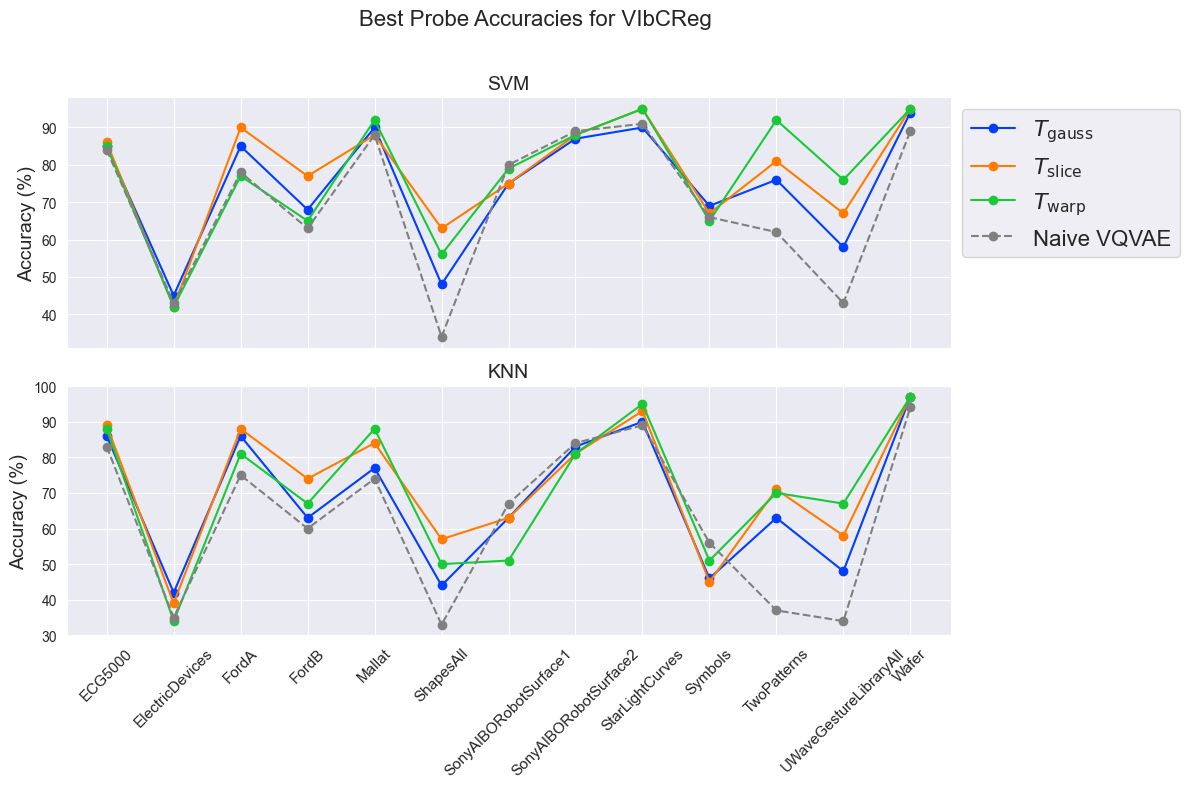

In [80]:
def plot_accuracy(ax, df, ssl_method, accuracy="svm_accuracy_max", aug_method=None, color=None, linestyle="-", label=""):
    # Filter the dataframe based on the SSL method and the augmentation method
    if aug_method:
        df_filtered = df[(df['SSL_method'] == ssl_method) & (df['Aug'] == aug_method)]
    else:
        df_filtered = df[df['SSL_method'] == ssl_method]

    # Sort the dataframe by dataset
    df_filtered = df_filtered.sort_values('dataset')

    # Plot the max SVM accuracy with a line style and color
    ax.plot(df_filtered['dataset'], df_filtered[accuracy] * 100, label=label, linestyle=linestyle, marker='o', color=color)
    ax.tick_params(axis='x', labelsize=11)  # Change the size of the x-axis labels

    return ax



sns.set_style("darkgrid")

# Set the color palette of seaborn
sns.set_palette("bright", 3)


# Create a new figure with two subplots that share the x-axis
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
f.suptitle("Best Probe Accuracies for VIbCReg", fontsize=16, x=0.45)
# Plot the max SVM accuracy
ax1.set_title('SVM', fontsize=14)
ax1.set_ylabel('Accuracy (%)', fontsize=14)
ax1 = plot_accuracy(ax1, summary_stage1, ssl_method='vibcreg', aug_method='gauss', label=r"$T_{\text{gauss}}$")
ax1 = plot_accuracy(ax1, summary_stage1, ssl_method='vibcreg', aug_method='slice', label=r"$T_{\text{slice}}$")
ax1 = plot_accuracy(ax1, summary_stage1, ssl_method='vibcreg', aug_method='warp', label=r"$T_{\text{warp}}$")
ax1 = plot_accuracy(ax1, summary_stage1, ssl_method='regular', color='grey', linestyle="--", label="Naive VQVAE")
ax1.legend(fontsize=16, loc='best', bbox_to_anchor=(1, 1))

# Plot the max KNN accuracy
ax2.set_title('KNN', fontsize=14)
ax2.set_ylabel('Accuracy (%)', fontsize=14)
ax2 = plot_accuracy(ax2, summary_stage1, accuracy="knn_accuracy_max", ssl_method='vibcreg', aug_method='gauss', label=r"$T_{\text{gauss}}$")
ax2 = plot_accuracy(ax2, summary_stage1, accuracy="knn_accuracy_max", ssl_method='vibcreg', aug_method='slice', label=r"$T_{\text{slice}}$")
ax2 = plot_accuracy(ax2, summary_stage1, accuracy="knn_accuracy_max", ssl_method='vibcreg', aug_method='warp', label=r"$T_{\text{warp}}$")
ax2 = plot_accuracy(ax2, summary_stage1, accuracy="knn_accuracy_max", ssl_method='regular', color='grey', linestyle="--", label="Naive VQVAE")
#ax2.legend(fontsize=14, loc='upper left', bbox_to_anchor=(1, 1))

# Rotate x-axis labels
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to accommodate the suptitle
#plt.savefig("probes_barlow_twins.pdf")
plt.show()


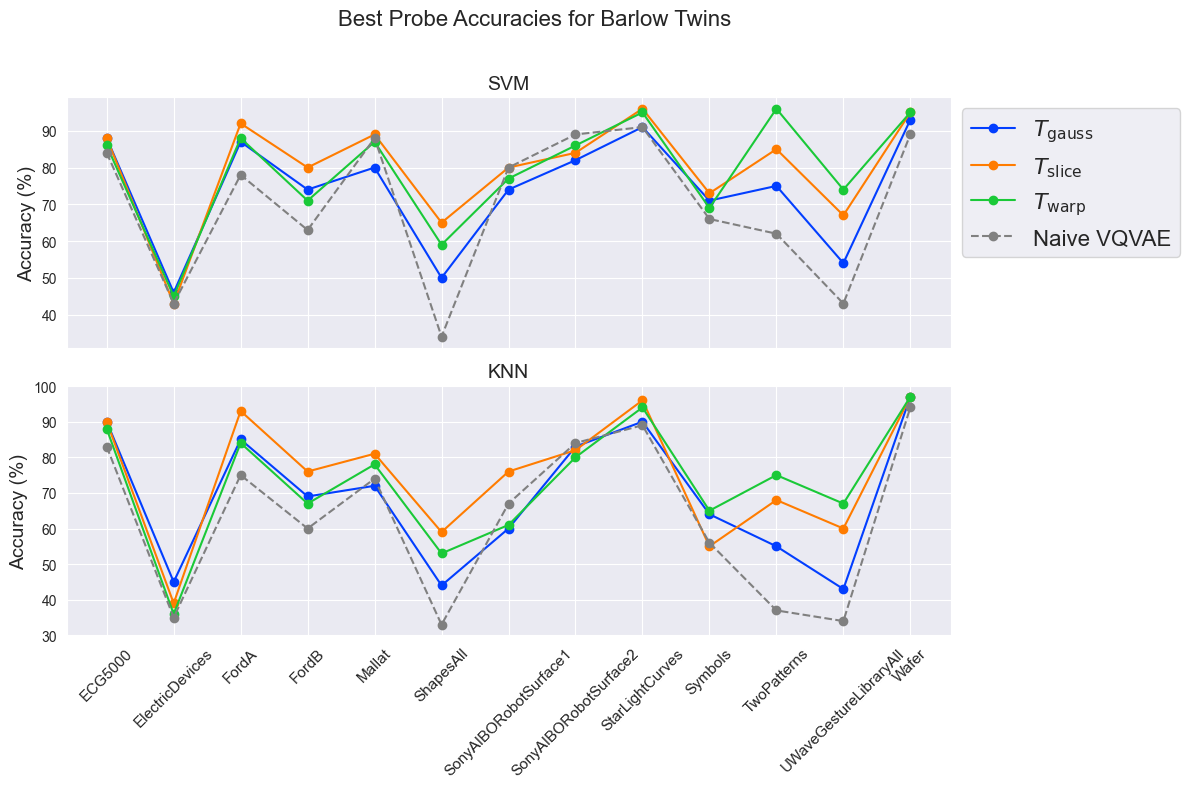

In [75]:
sns.set_style("darkgrid")

# Set the color palette of seaborn
sns.set_palette("bright", 3)

# Create a new figure
#f, a = plt.subplots(figsize=(12, 4))


# Create a new figure with two subplots that share the x-axis
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
f.suptitle("Best Probe Accuracies for Barlow Twins", fontsize=16, x=0.45)
# Plot the max SVM accuracy
ax1.set_title('SVM', fontsize=14)
ax1.set_ylabel('Accuracy (%)', fontsize=14)
ax1 = plot_accuracy(ax1, summary_stage1, ssl_method='barlowtwins', aug_method='gauss', label=r"$T_{\text{gauss}}$")
ax1 = plot_accuracy(ax1, summary_stage1, ssl_method='barlowtwins', aug_method='slice', label=r"$T_{\text{slice}}$")
ax1 = plot_accuracy(ax1, summary_stage1, ssl_method='barlowtwins', aug_method='warp', label=r"$T_{\text{warp}}$")
ax1 = plot_accuracy(ax1, summary_stage1, ssl_method='regular', color='grey', linestyle="--", label="Naive VQVAE")
ax1.legend(fontsize=16, loc='upper left', bbox_to_anchor=(1, 1))

# Plot the max KNN accuracy
ax2.set_title('KNN', fontsize=14)
ax2.set_ylabel('Accuracy (%)', fontsize=14)
ax2 = plot_accuracy(ax2, summary_stage1, accuracy="knn_accuracy_max", ssl_method='barlowtwins', aug_method='gauss', label=r"$T_{\text{gauss}}$")
ax2 = plot_accuracy(ax2, summary_stage1, accuracy="knn_accuracy_max", ssl_method='barlowtwins', aug_method='slice', label=r"$T_{\text{slice}}$")
ax2 = plot_accuracy(ax2, summary_stage1, accuracy="knn_accuracy_max", ssl_method='barlowtwins', aug_method='warp', label=r"$T_{\text{warp}}$")
ax2 = plot_accuracy(ax2, summary_stage1, accuracy="knn_accuracy_max", ssl_method='regular', color='grey', linestyle="--", label="Naive VQVAE")
#ax2.legend(fontsize=14, loc='upper left', bbox_to_anchor=(1, 1))

# Rotate x-axis labels
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to accommodate the suptitle
#plt.savefig("probes_barlow_twins.pdf")
plt.show()

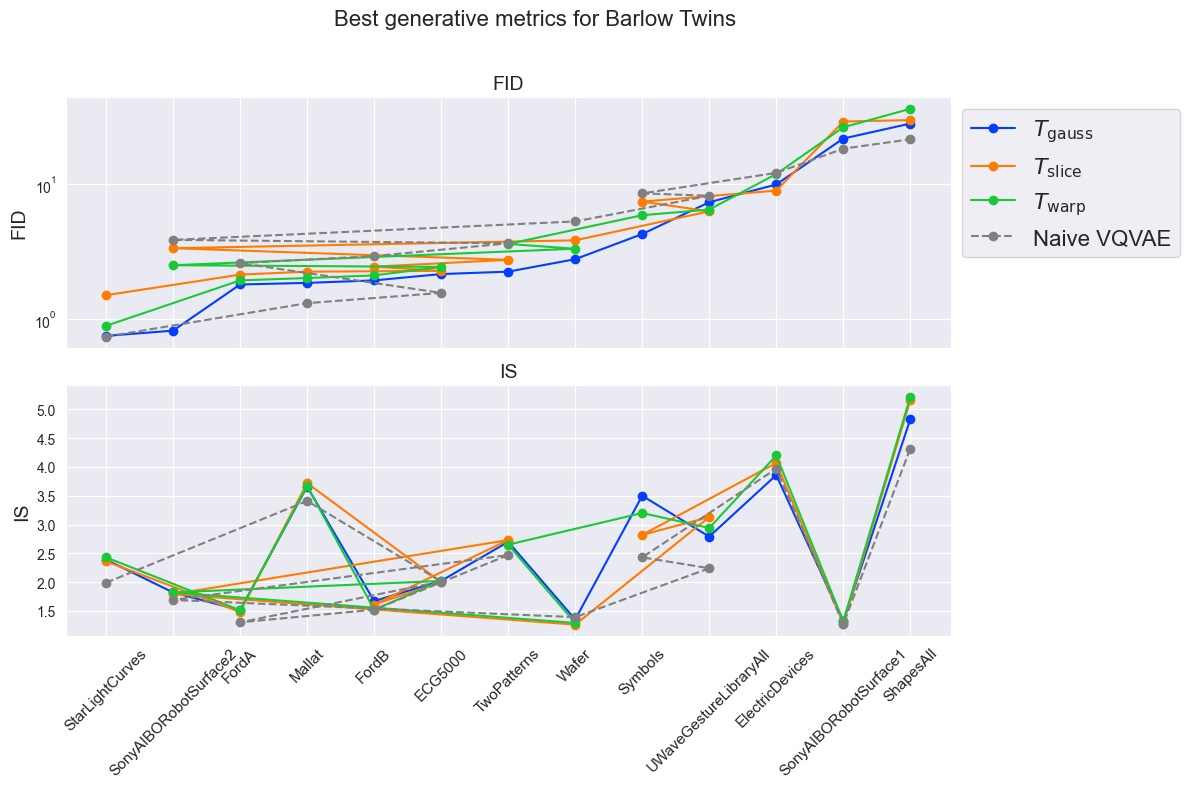

In [86]:
def plot_FID_IS(ax, df, ssl_method, metric = "FID_min", aug_method=None, color=None, linestyle="-", label=""):
    # Filter the dataframe based on the SSL method and the augmentation method
    if aug_method:
        df_filtered = df[(df['SSL_method'] == ssl_method) & (df['Aug'] == aug_method)]
    else:
        df_filtered = df[df['SSL_method'] == ssl_method]

    # Sort the dataframe by dataset
    df_filtered = df_filtered.sort_values('IS_mean_max')
    df_filtered = df_filtered.sort_values('FID_min')
    df_filtered = df_filtered.sort_values('dataset')

    
    # Plot the max SVM accuracy with a line style and color
    
    ax.plot(df_filtered['dataset'], df_filtered[metric], label=label, linestyle=linestyle, marker='o', color=color)
    ax.tick_params(axis='x', labelsize=11)  # Change the size of the x-axis labels

    return ax

# Set the style of seaborn

sns.set_style("darkgrid")

# Set the color palette of seaborn
sns.set_palette("bright", 3)

# Create a new figure
#f, a = plt.subplots(figsize=(12, 4))


# Create a new figure with two subplots that share the x-axis
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
f.suptitle("Best generative metrics for Barlow Twins", fontsize=16, x=0.45)
# Plot the max FID score
ax1.set_title('FID', fontsize=14)
ax1.set_ylabel('FID', fontsize=14)
ax1.set_yscale('log')
ax1 = plot_FID_IS(ax1, summary_stage2,metric = "FID_min", ssl_method='barlowtwins', aug_method='gauss', label=r"$T_{\text{gauss}}$")
ax1 = plot_FID_IS(ax1, summary_stage2,metric = "FID_min", ssl_method='barlowtwins', aug_method='slice', label=r"$T_{\text{slice}}$")
ax1 = plot_FID_IS(ax1, summary_stage2,metric = "FID_min", ssl_method='barlowtwins', aug_method='warp', label=r"$T_{\text{warp}}$")
ax1 = plot_FID_IS(ax1, summary_stage2,metric = "FID_min", ssl_method='regular', color='grey', linestyle="--", label="Naive VQVAE")
ax1.legend(fontsize=16, loc='best', bbox_to_anchor=(1, 1))

# Plot the max IS score
ax2.set_title('IS', fontsize=14)
ax2.set_ylabel('IS', fontsize=14)

ax2 = plot_FID_IS(ax2, summary_stage2, metric="IS_mean_max", ssl_method='barlowtwins', aug_method='gauss', label=r"$T_{\text{gauss}}$")
ax2 = plot_FID_IS(ax2, summary_stage2, metric="IS_mean_max", ssl_method='barlowtwins', aug_method='slice', label=r"$T_{\text{slice}}$")
ax2 = plot_FID_IS(ax2, summary_stage2, metric="IS_mean_max", ssl_method='barlowtwins', aug_method='warp', label=r"$T_{\text{warp}}$")
ax2 = plot_FID_IS(ax2, summary_stage2, metric="IS_mean_max", ssl_method='regular', color='grey', linestyle="--", label="Naive VQVAE")
#ax2.legend(fontsize=14, loc='upper left', bbox_to_anchor=(1, 1))

# Rotate x-axis labels
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to accommodate the suptitle
#plt.savefig("probes_barlow_twins.pdf")
plt.show()

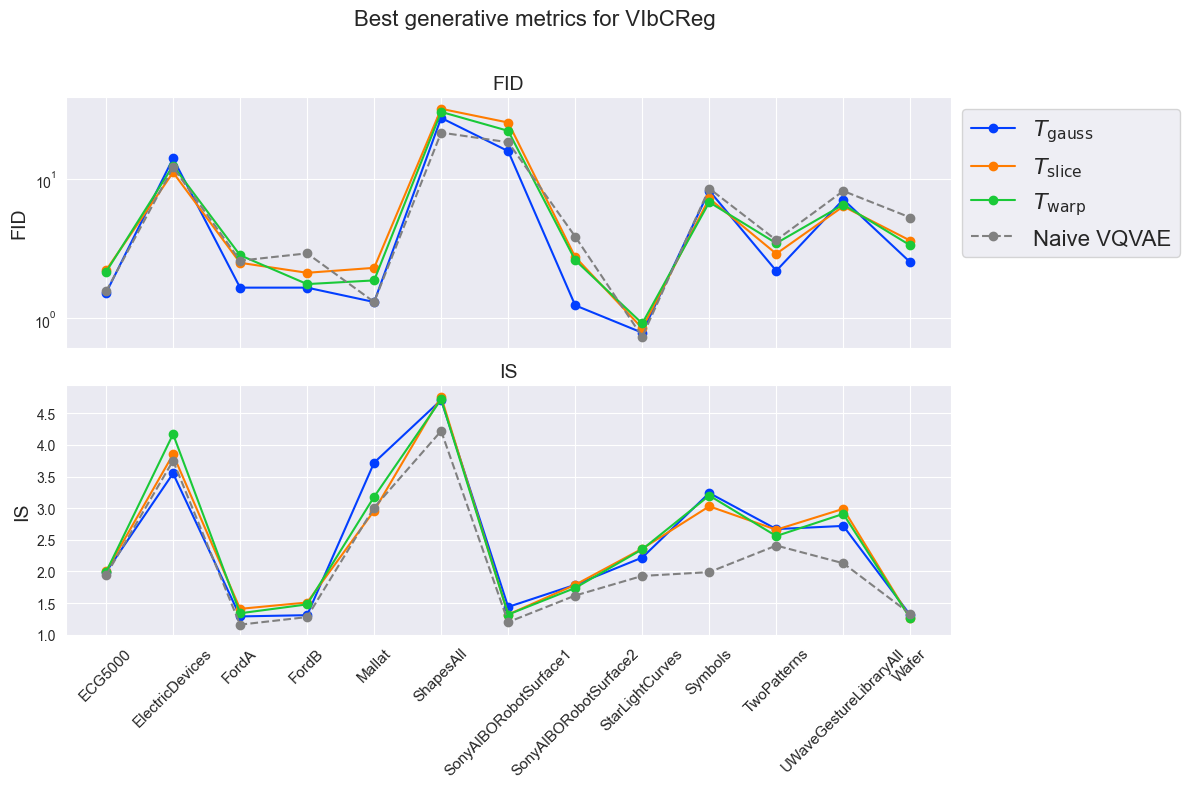

In [83]:
sns.set_style("darkgrid")

# Set the color palette of seaborn
sns.set_palette("bright", 3)


# Create a new figure with two subplots that share the x-axis
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
f.suptitle("Best generative metrics for VIbCReg", fontsize=16, x=0.45)
# Plot the max FID score
ax1.set_title('FID', fontsize=14)
ax1.set_ylabel('FID', fontsize=14)
ax1.set_yscale('log')
ax1 = plot_FID_IS(ax1, summary_stage2,metric = "FID_min", ssl_method='vibcreg', aug_method='gauss', label=r"$T_{\text{gauss}}$")
ax1 = plot_FID_IS(ax1, summary_stage2,metric = "FID_min", ssl_method='vibcreg', aug_method='slice', label=r"$T_{\text{slice}}$")
ax1 = plot_FID_IS(ax1, summary_stage2,metric = "FID_min", ssl_method='vibcreg', aug_method='warp', label=r"$T_{\text{warp}}$")
ax1 = plot_FID_IS(ax1, summary_stage2,metric = "FID_min", ssl_method='regular', color='grey', linestyle="--", label="Naive VQVAE")
ax1.legend(fontsize=16, loc='best', bbox_to_anchor=(1, 1))

# Plot the max IS score
ax2.set_title('IS', fontsize=14)
ax2.set_ylabel('IS', fontsize=14)

ax2 = plot_FID_IS(ax2, summary_stage2, metric="IS_mean_mean", ssl_method='vibcreg', aug_method='gauss', label=r"$T_{\text{gauss}}$")
ax2 = plot_FID_IS(ax2, summary_stage2, metric="IS_mean_mean", ssl_method='vibcreg', aug_method='slice', label=r"$T_{\text{slice}}$")
ax2 = plot_FID_IS(ax2, summary_stage2, metric="IS_mean_mean", ssl_method='vibcreg', aug_method='warp', label=r"$T_{\text{warp}}$")
ax2 = plot_FID_IS(ax2, summary_stage2, metric="IS_mean_mean", ssl_method='regular', color='grey', linestyle="--", label="Naive VQVAE")
#ax2.legend(fontsize=14, loc='upper left', bbox_to_anchor=(1, 1))

# Rotate x-axis labels
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to accommodate the suptitle
#plt.savefig("probes_barlow_twins.pdf")
plt.show()

In [44]:
mean_summary =  split_and_apply(pd.merge(summary_df_stage1_mean, summary_df_stage2_mean, how="inner"))

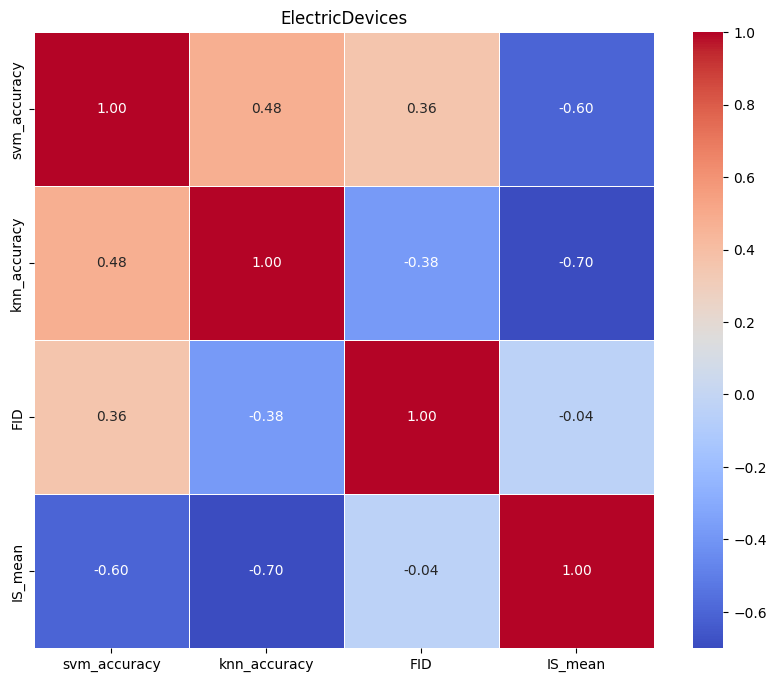

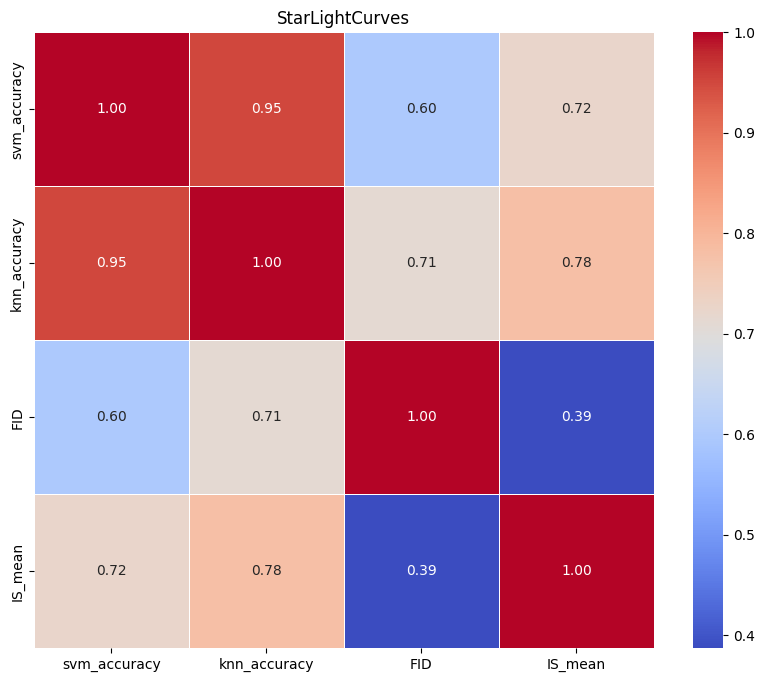

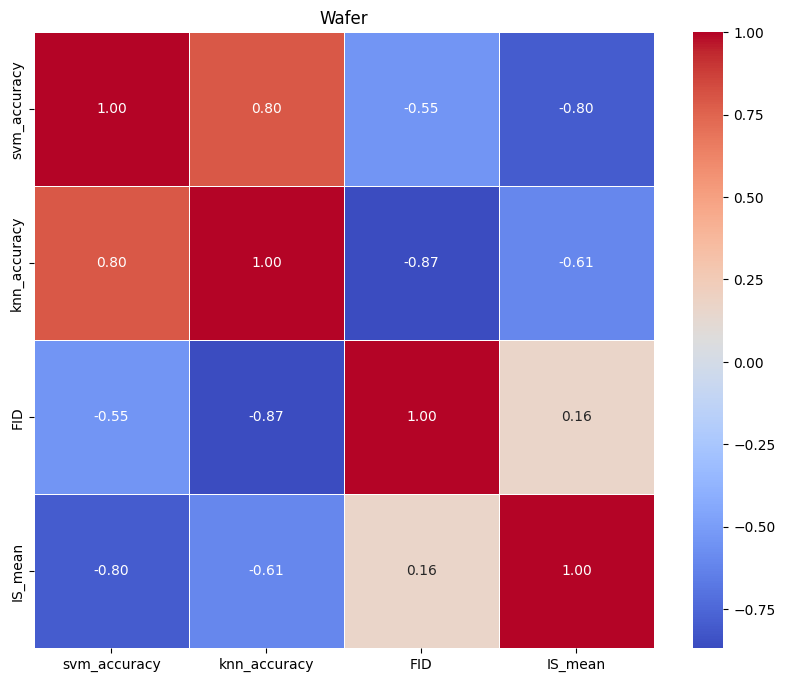

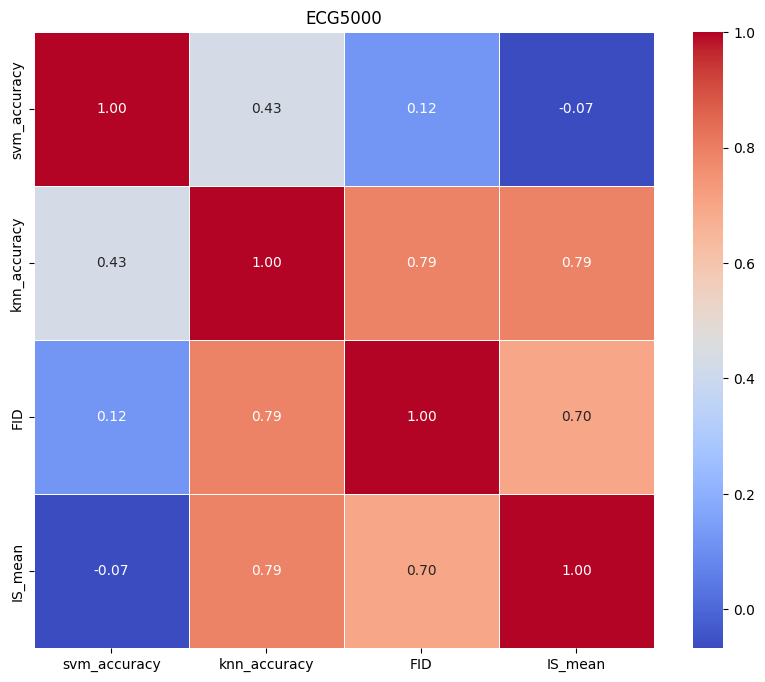

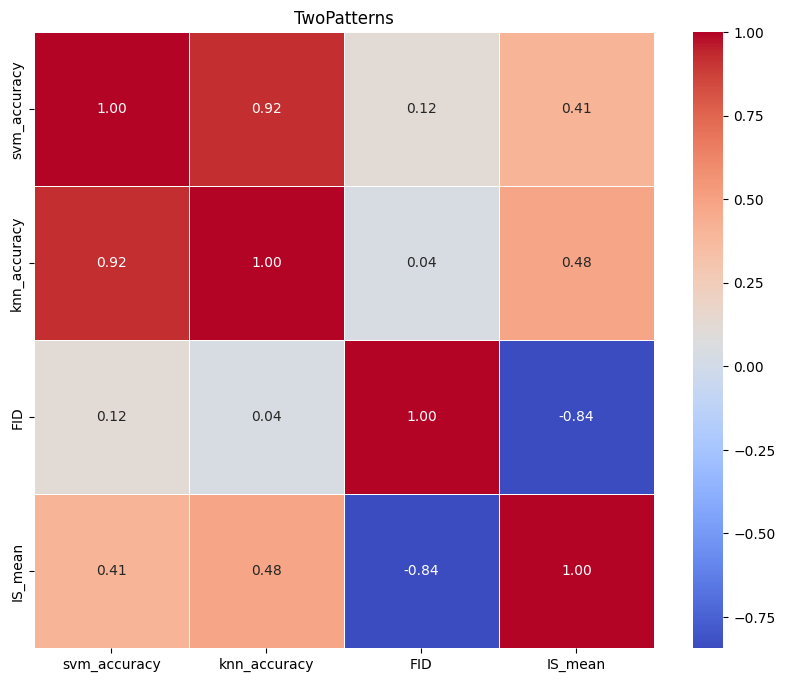

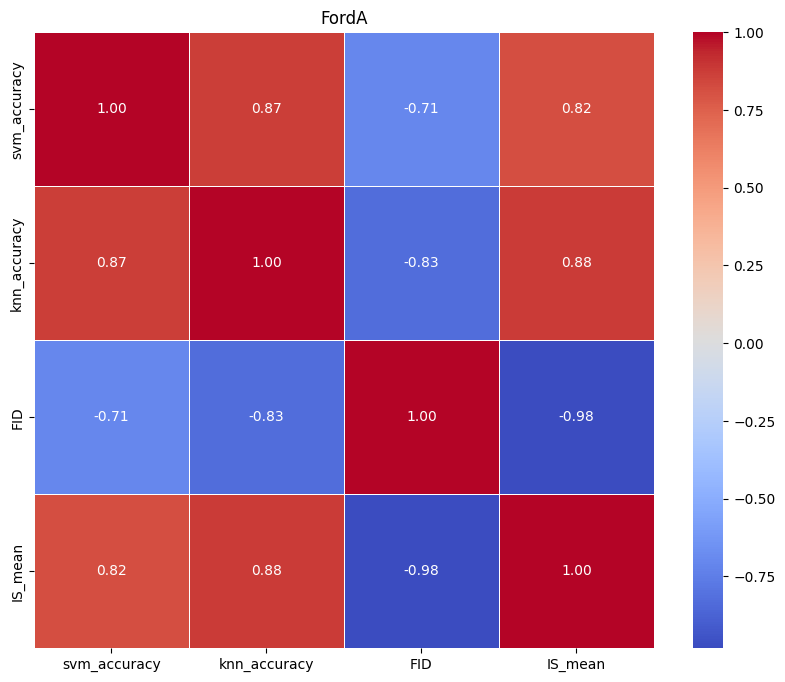

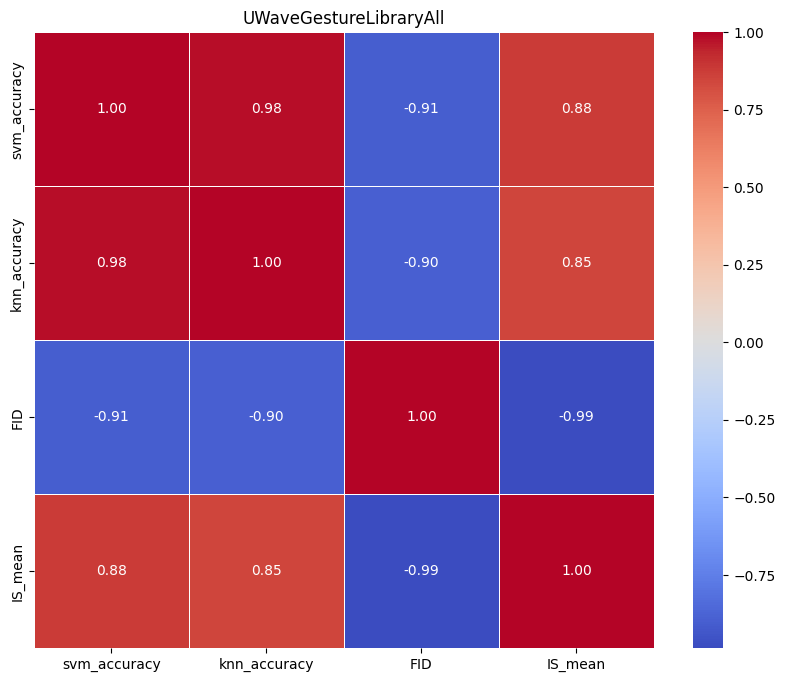

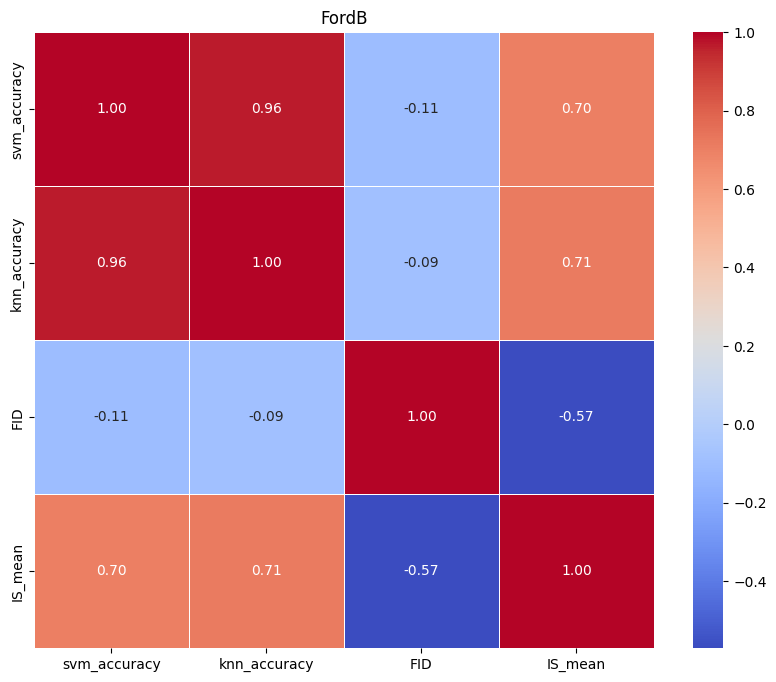

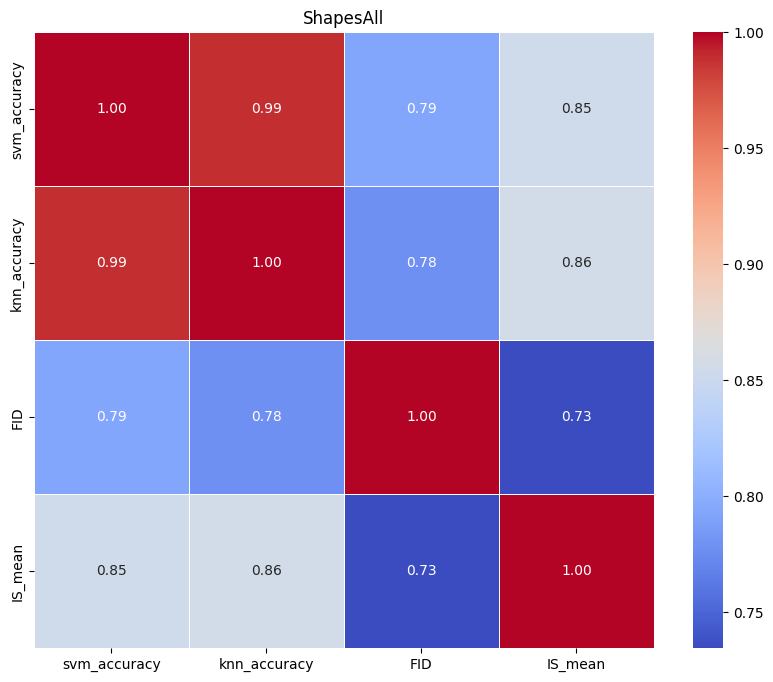

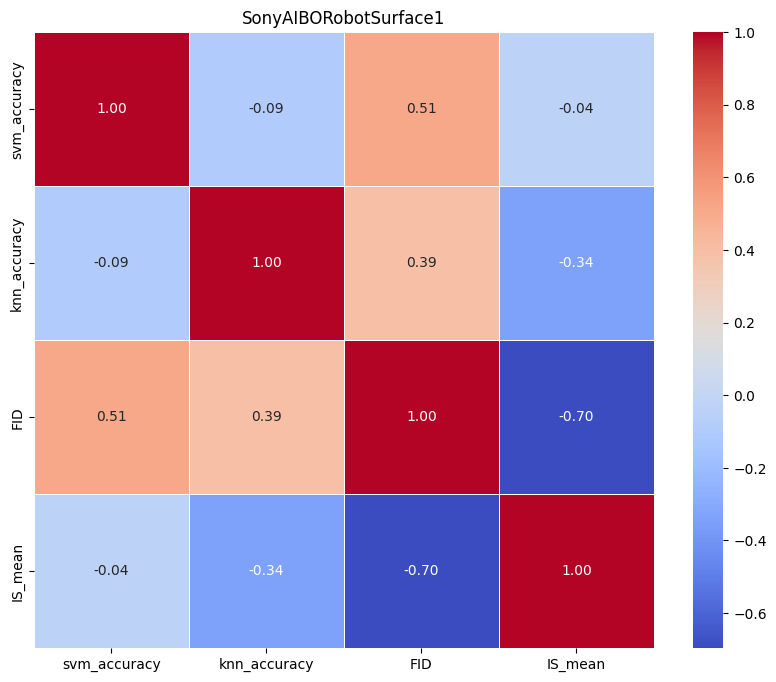

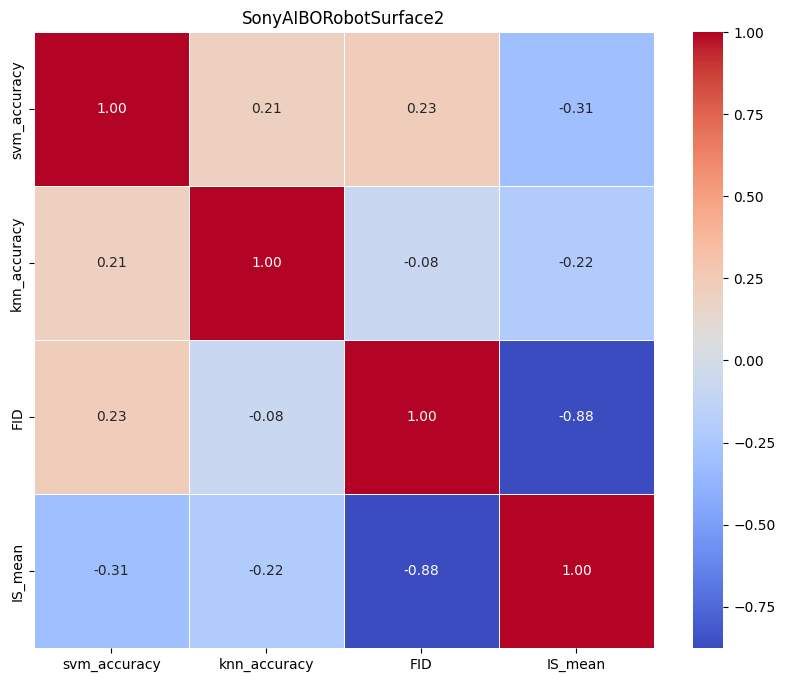

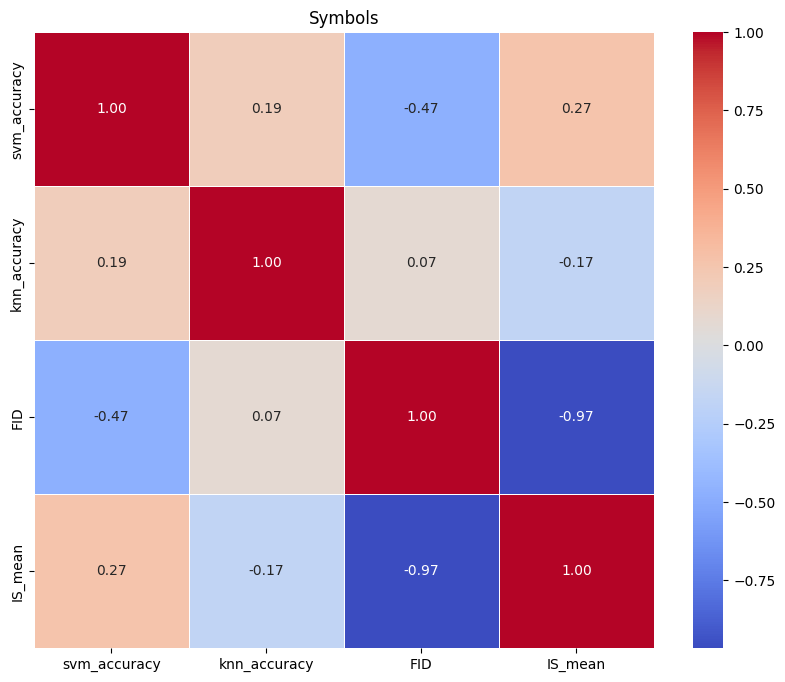

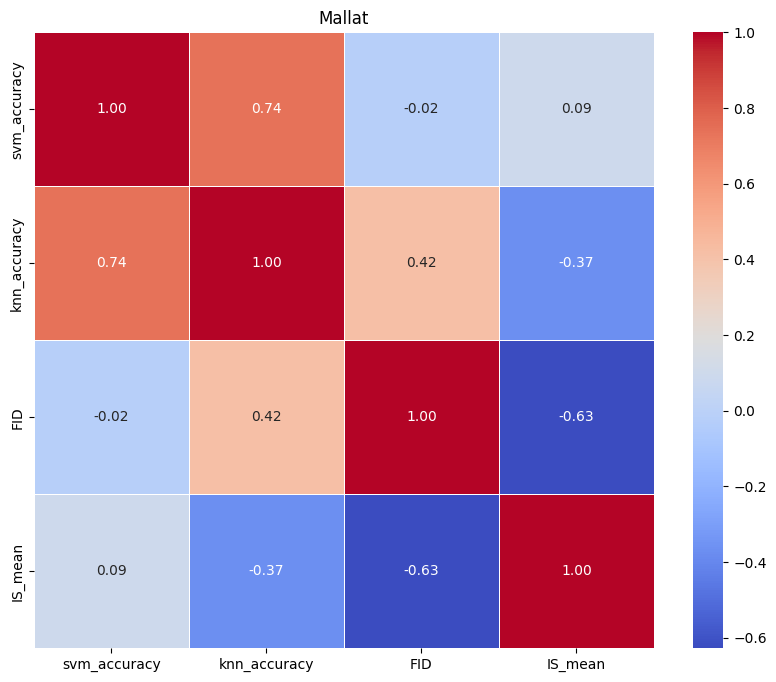

In [58]:
for dataset in datasets:
    df = summary[summary["dataset"] == dataset]
    df = df[['svm_accuracy', 'knn_accuracy', 'FID', 'IS_mean']]

    # Calculate the correlation matrix
    correlation_matrix = df.corr()

    # Display the correlation matrix
    # print(correlation_matrix)

    # Visualize the correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title(dataset)
    plt.show()

In [29]:
all_summaries_stage2

,FID,IS_mean,IS_std,run_id,method,dataset
0,15.435189,3.488721,0.095249,ru4kg8h6,regular,ElectricDevices
1,12.541792,3.974428,0.083165,kv3h91x5,regular,ElectricDevices
2,12.051533,3.770713,0.082911,iijb7fyj,regular,ElectricDevices
3,13.886247,3.779307,0.122453,od7sy5t9,regular,ElectricDevices
0,13.357634,4.233015,0.095361,2duaif75,vibcreg_warp,ElectricDevices
...,...,...,...,...,...,...
3,3.614945,2.979197,0.061357,qcobjqle,barlowtwins_slice,Mallat
0,2.151978,3.330563,0.077273,devlygmo,barlowtwins_gauss,Mallat
1,2.024830,3.492853,0.074225,7uaox47d,barlowtwins_gauss,Mallat
2,2.461450,3.638705,0.121110,0rfcbrbi,barlowtwins_gauss,Mallat


/var/folders/tz/7b83mvms205g7153tt6m1lnr0000gn/T/ipykernel_55621/1871951217.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a[datasets.index(dataset)][0].set_xticklabels(a[datasets.index(dataset)][0].get_xticklabels(), rotation=45)  # Rotate x-axis labels
/var/folders/tz/7b83mvms205g7153tt6m1lnr0000gn/T/ipykernel_55621/1871951217.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a[datasets.index(dataset)][1].set_xticklabels(a[datasets.index(dataset)][1].get_xticklabels(), rotation=45)  # Rotate x-axis labels
/var/folders/tz/7b83mvms205g7153tt6m1lnr0000gn/T/ipykernel_55621/1871951217.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a[datasets.index(dataset)][0].set_xticklabels(a[datasets.index(dataset)][0].get_xticklabels(), ro

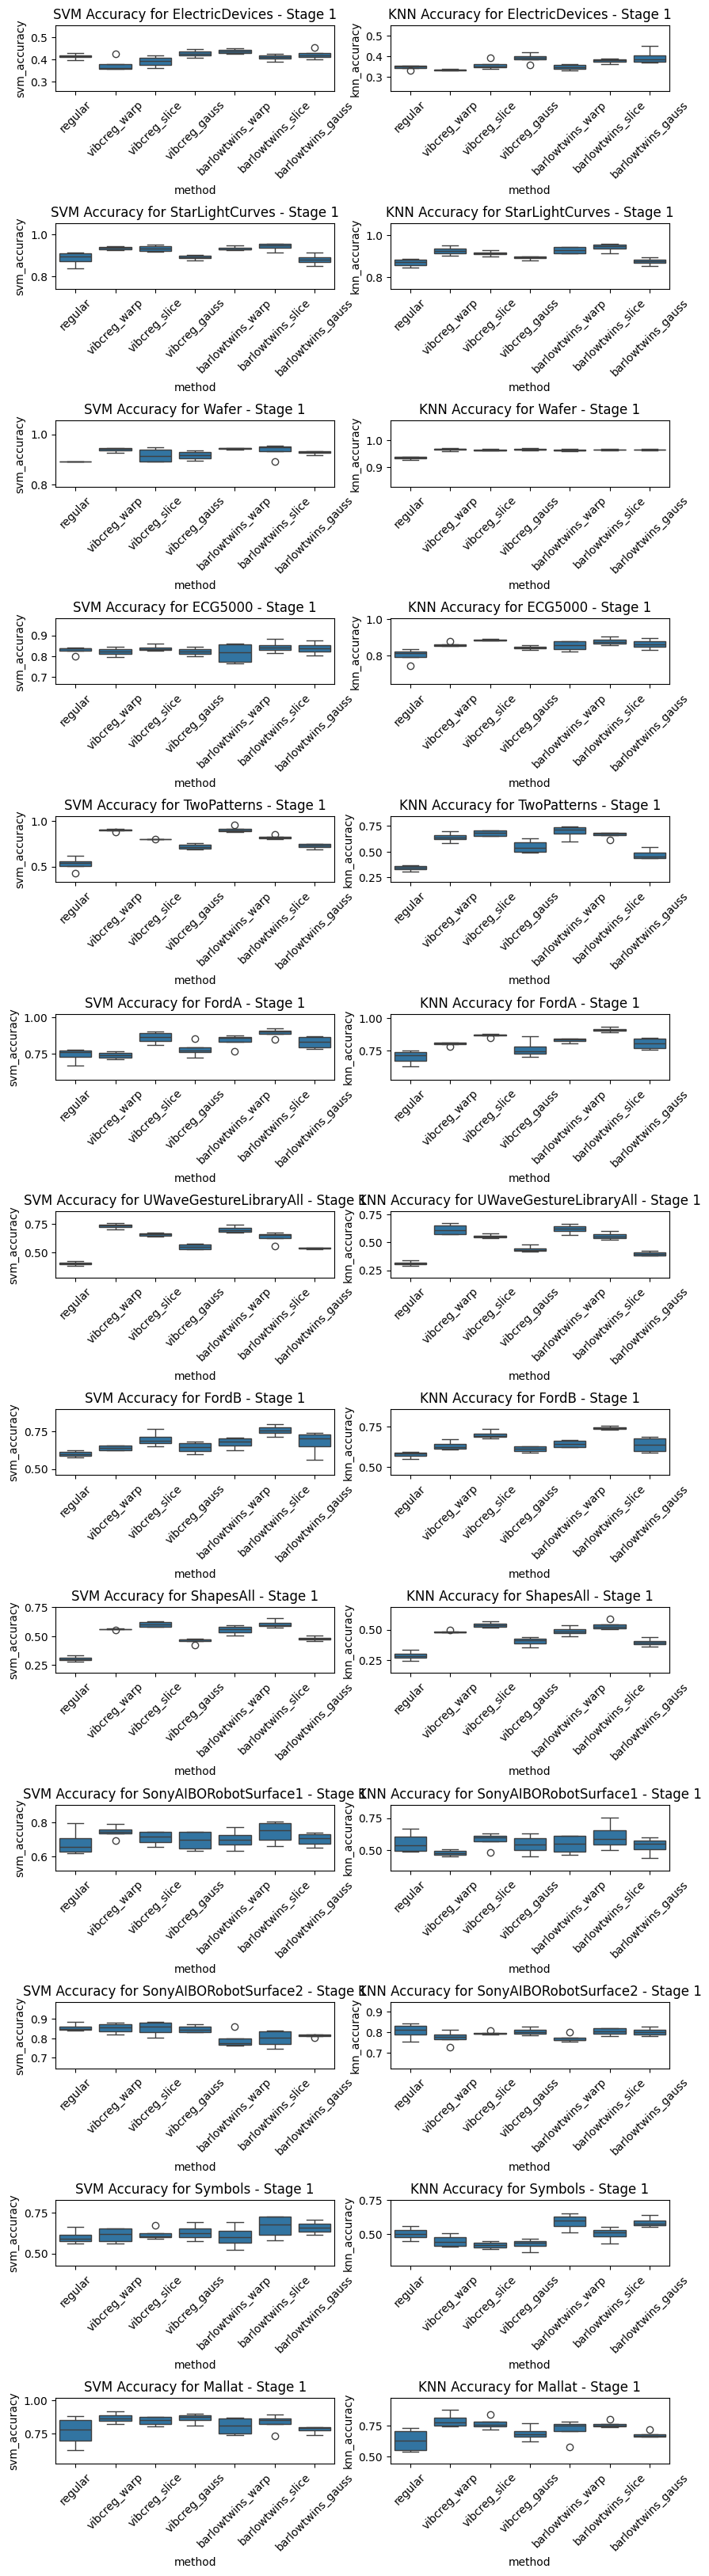

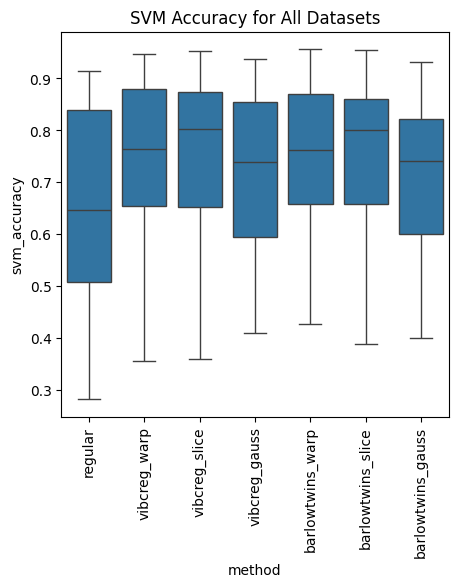

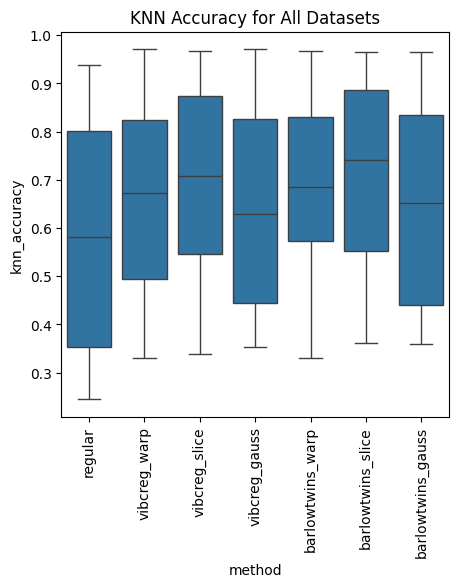

In [10]:
# methods = ["regular", "byol", "barlowtwins", "vibcreg"]  # Replace with your actual methods

f, a = plt.subplots(len(datasets), 2, figsize=(10, 40))
for dataset in datasets:
    data_svm = all_summaries_stage1[(all_summaries_stage1["dataset"] == dataset) & (all_summaries_stage1["method"].isin(methods))]
    data_knn = all_summaries_stage1[(all_summaries_stage1["dataset"] == dataset) & (all_summaries_stage1["method"].isin(methods))]
    
    min_svm, max_svm = data_svm['svm_accuracy'].min(), data_svm['svm_accuracy'].max()
    min_knn, max_knn = data_knn['knn_accuracy'].min(), data_knn['knn_accuracy'].max()

    sns.boxplot(x="method", y="svm_accuracy", data=data_svm, ax=a[datasets.index(dataset)][0])
    a[datasets.index(dataset)][0].set_title(f"SVM Accuracy for {dataset} - Stage 1")
    a[datasets.index(dataset)][0].set_xticklabels(a[datasets.index(dataset)][0].get_xticklabels(), rotation=45)  # Rotate x-axis labels
    a[datasets.index(dataset)][0].set_ylim(min_svm - 0.1, max_svm + 0.1)  # Adjust y-axis limits

    sns.boxplot(x="method", y="knn_accuracy", data=data_knn, ax=a[datasets.index(dataset)][1])
    a[datasets.index(dataset)][1].set_title(f"KNN Accuracy for {dataset} - Stage 1")
    a[datasets.index(dataset)][1].set_xticklabels(a[datasets.index(dataset)][1].get_xticklabels(), rotation=45)  # Rotate x-axis labels
    a[datasets.index(dataset)][1].set_ylim(min_knn - 0.1, max_knn + 0.1)  # Adjust y-axis limits

plt.subplots_adjust(hspace = 2)  # Add more vertical spacing between subplots
plt.savefig('results/boxplot.png', dpi = 300)
plt.show()

plt.figure(figsize=(5, 5))
sns.boxplot(x="method", y="svm_accuracy", data=all_summaries_stage1[all_summaries_stage1["method"].isin(methods)])
plt.title("SVM Accuracy for All Datasets")
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(5, 5))
sns.boxplot(x="method", y="knn_accuracy", data=all_summaries_stage1[all_summaries_stage1["method"].isin(methods)])
plt.title("KNN Accuracy for All Datasets")
plt.xticks(rotation=90)
plt.show()

In [12]:
# f, a = plt.subplots(len(datasets), 2, figsize=(10, 40))
# for dataset in datasets:
#     data_svm = all_summaries_stage1[all_summaries_stage1["dataset"] == dataset]
#     data_knn = all_summaries_stage1[all_summaries_stage1["dataset"] == dataset]
#     min_svm, max_svm = data_svm['svm_accuracy'].min(), data_svm['svm_accuracy'].max()
#     min_knn, max_knn = data_knn['knn_accuracy'].min(), data_knn['knn_accuracy'].max()

#     sns.boxplot(x="method", y="svm_accuracy", data=all_summaries_stage1[all_summaries_stage1["dataset"] == dataset], ax=a[datasets.index(dataset)][0])
#     a[datasets.index(dataset)][0].set_title(f"SVM Accuracy for {dataset} - Stage 1")
#     a[datasets.index(dataset)][0].set_xticklabels(a[datasets.index(dataset)][0].get_xticklabels(), rotation=45)  # Rotate x-axis labels
#     a[datasets.index(dataset)][0].set_ylim(min_svm - 0.1, max_svm + 0.1)  # Adjust y-axis limits

    
#     sns.boxplot(x="method", y="knn_accuracy", data=all_summaries_stage1[all_summaries_stage1["dataset"] == dataset], ax=a[datasets.index(dataset)][1])
#     a[datasets.index(dataset)][1].set_title(f"KNN Accuracy for {dataset} - Stage 1")
#     a[datasets.index(dataset)][1].set_xticklabels(a[datasets.index(dataset)][1].get_xticklabels(), rotation=45)  # Rotate x-axis labels
#     a[datasets.index(dataset)][1].set_ylim(min_knn - 0.1, max_knn + 0.1)  # Adjust y-axis limits

# plt.subplots_adjust(hspace = 1)  # Add more vertical spacing between subplots
# plt.savefig('results/boxplot.png', dpi = 300)
# plt.show()

# plt.figure(figsize=(5, 5))
# sns.boxplot(x="method", y="svm_accuracy", data=all_summaries_stage1)
# plt.title("SVM Accuracy for All Datasets")
# plt.xticks(rotation=90)
# plt.show()

# plt.figure(figsize=(5, 5))
# sns.boxplot(x="method", y="knn_accuracy", data=all_summaries_stage1)
# plt.title("KNN Accuracy for All Datasets")
# plt.xticks(rotation=90)
# plt.show()

# plt.figure(figsize=(5, 5))
# sns.boxplot(x="method", y="val_loss", data=all_summaries_stage1)
# plt.title("Validation Loss for All Datasets")
# plt.xticks(rotation=90)
# plt.show()

/var/folders/tz/7b83mvms205g7153tt6m1lnr0000gn/T/ipykernel_55621/1225494271.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a[datasets.index(dataset)][0].set_xticklabels(a[datasets.index(dataset)][0].get_xticklabels(), rotation=45)  # Rotate x-axis labels
/var/folders/tz/7b83mvms205g7153tt6m1lnr0000gn/T/ipykernel_55621/1225494271.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a[datasets.index(dataset)][1].set_xticklabels(a[datasets.index(dataset)][1].get_xticklabels(), rotation=45)  # Rotate x-axis labels
/var/folders/tz/7b83mvms205g7153tt6m1lnr0000gn/T/ipykernel_55621/1225494271.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a[datasets.index(dataset)][0].set_xticklabels(a[datasets.index(dataset)][0].get_xticklabels(), ro

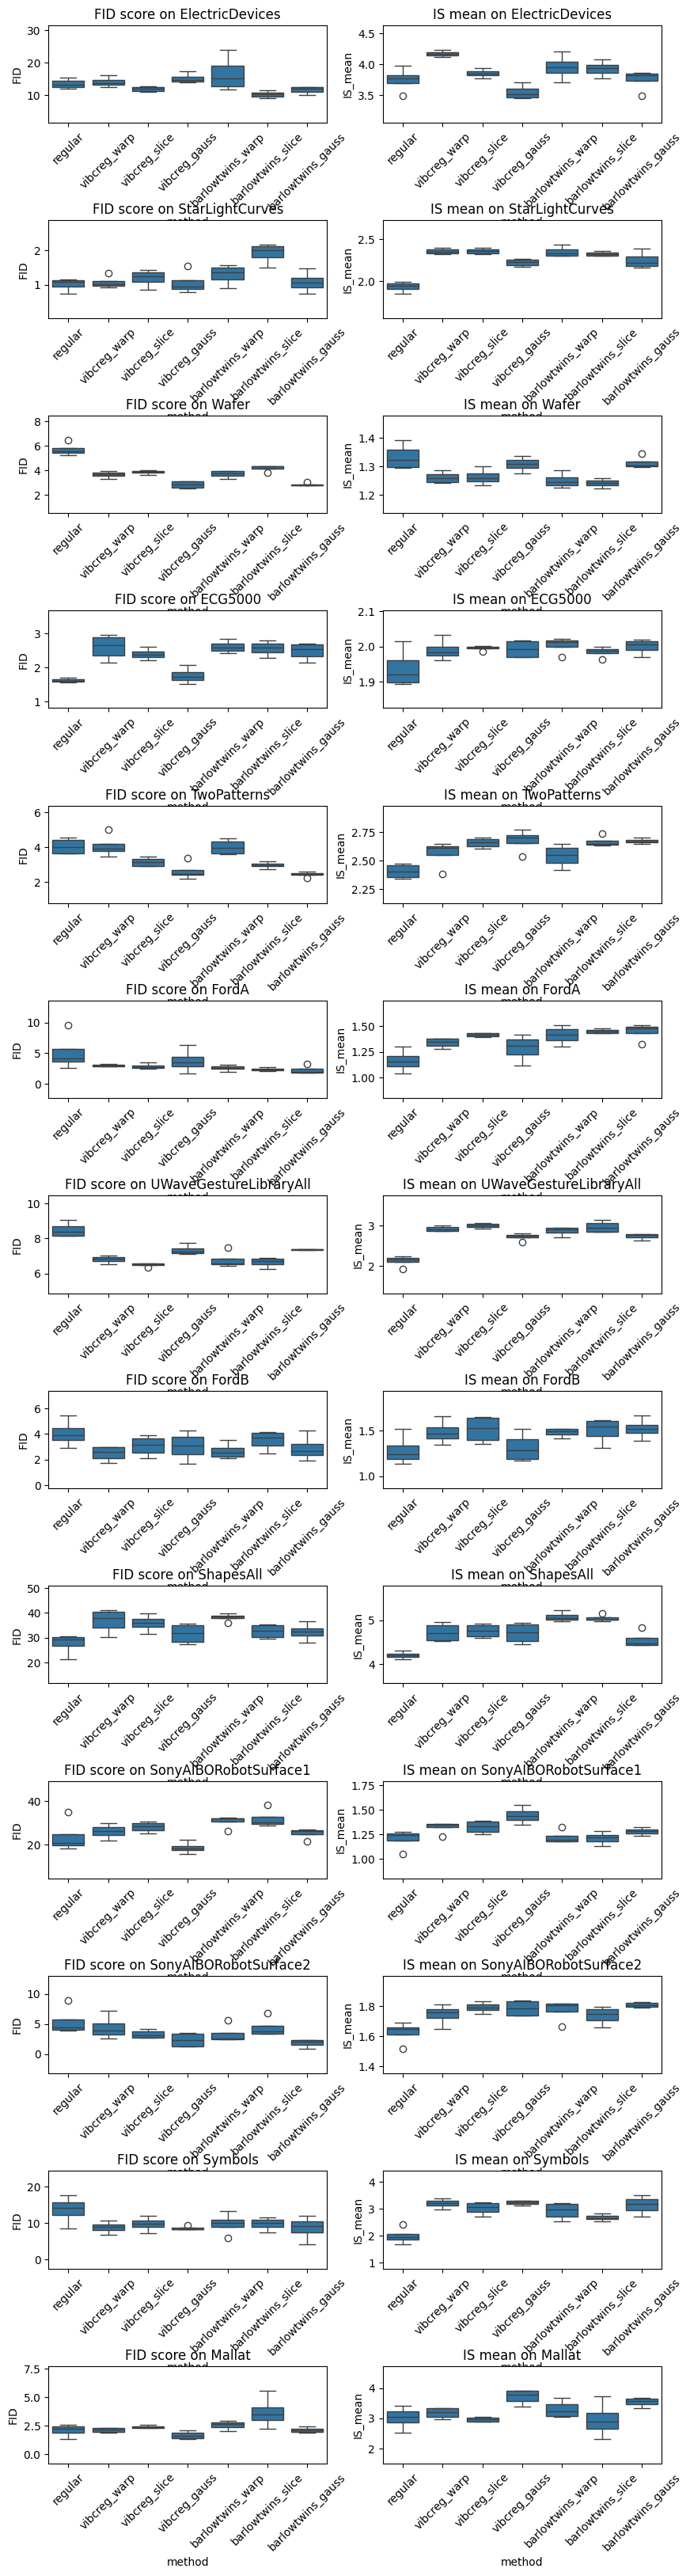

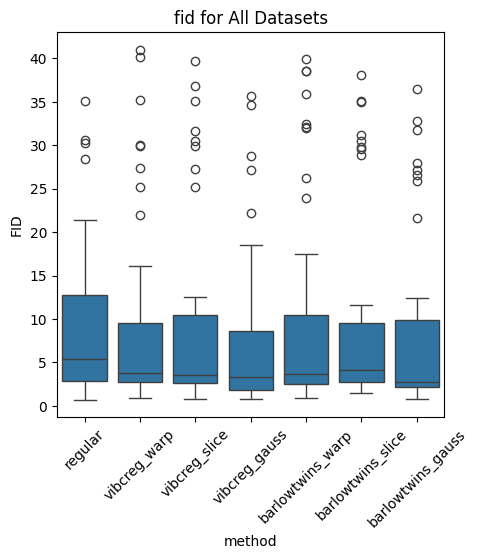

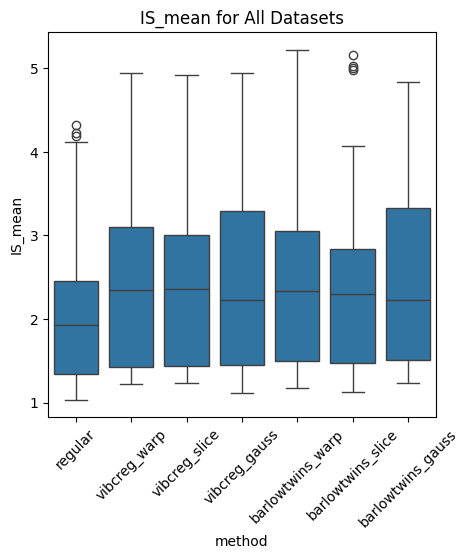

In [13]:
f, a = plt.subplots(len(datasets), 2, figsize=(10, 40))
for dataset in datasets:
    data_fid = all_summaries_stage2[all_summaries_stage2["dataset"] == dataset]
    data_is = all_summaries_stage2[all_summaries_stage2["dataset"] == dataset]
    
    min_fid, max_fid = data_fid['FID'].min(), data_fid['FID'].max()
    min_is, max_is = data_is['IS_mean'].min(), data_is['IS_mean'].max()
    
    sns.boxplot(x="method", y="FID", data=data_fid, ax=a[datasets.index(dataset)][0])
    a[datasets.index(dataset)][0].set_title(f"FID score on {dataset}")
    a[datasets.index(dataset)][0].set_xticklabels(a[datasets.index(dataset)][0].get_xticklabels(), rotation=45)  # Rotate x-axis labels
    a[datasets.index(dataset)][0].set_ylim(min_fid - 0.5 * (max_fid - min_fid), max_fid + 0.5 * (max_fid - min_fid))  # Adjust y-axis limits

    sns.boxplot(x="method", y="IS_mean", data=data_is, ax=a[datasets.index(dataset)][1])
    a[datasets.index(dataset)][1].set_title(f"IS mean on {dataset}")
    a[datasets.index(dataset)][1].set_xticklabels(a[datasets.index(dataset)][1].get_xticklabels(), rotation=45)  # Rotate x-axis labels
    a[datasets.index(dataset)][1].set_ylim(min_is - 0.5 * (max_is - min_is), max_is + 0.5 * (max_is - min_is))  # Adjust y-axis limits

plt.subplots_adjust(hspace = 1)  # Add more vertical spacing between subplots
plt.savefig('results/boxplot2.png', dpi = 300)
plt.show()

plt.figure(figsize=(5, 5))
sns.boxplot(x="method", y="FID", data=all_summaries_stage2)
plt.title("fid for All Datasets")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(5, 5))
sns.boxplot(x="method", y="IS_mean", data=all_summaries_stage2)
plt.title("IS_mean for All Datasets")
plt.xticks(rotation=45)
plt.show()

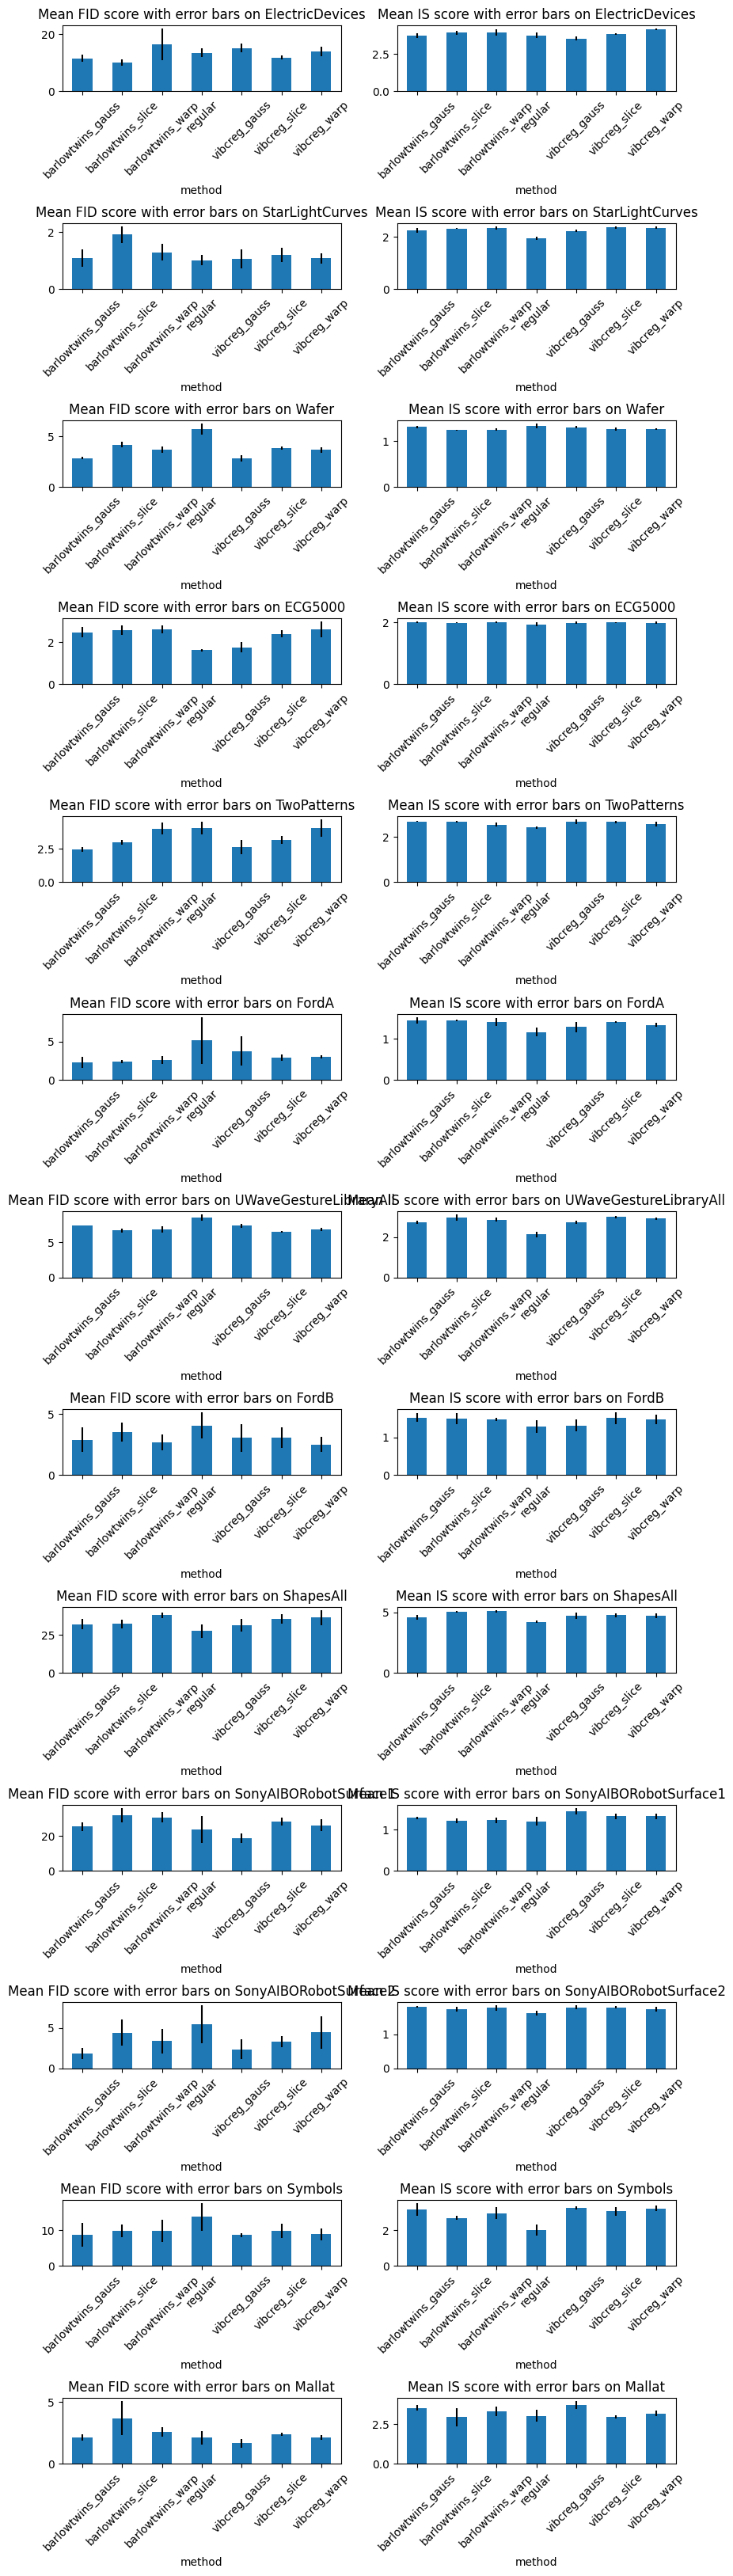

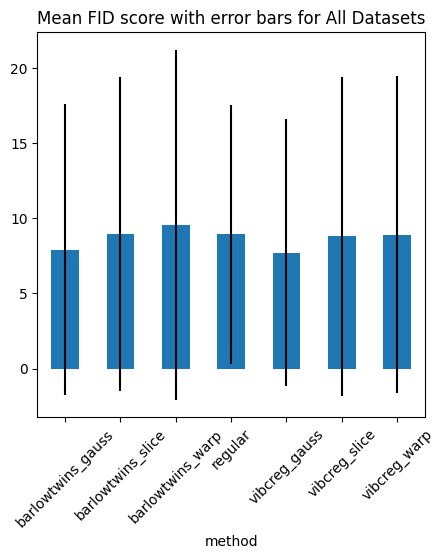

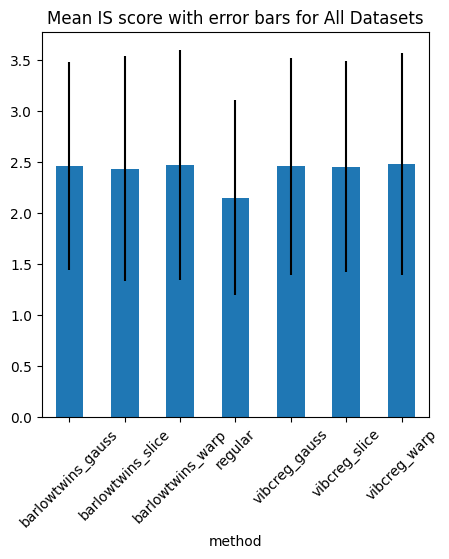

In [15]:
#Something is fucked
f, a = plt.subplots(len(datasets), 2, figsize=(10, 40))
for dataset in datasets:
    data_fid = all_summaries_stage2[all_summaries_stage2["dataset"] == dataset]
    data_is = all_summaries_stage2[all_summaries_stage2["dataset"] == dataset]
    
    data_fid.groupby('method')['FID'].mean().plot(kind='bar', yerr=data_fid.groupby('method')['FID'].std(), ax=a[datasets.index(dataset)][0])
    a[datasets.index(dataset)][0].set_title(f"Mean FID score with error bars on {dataset}")
    a[datasets.index(dataset)][0].set_xticklabels(a[datasets.index(dataset)][0].get_xticklabels(), rotation=45)  # Rotate x-axis labels

    data_is.groupby('method')['IS_mean'].mean().plot(kind='bar', yerr=data_is.groupby('method')['IS_mean'].std(), ax=a[datasets.index(dataset)][1])
    a[datasets.index(dataset)][1].set_title(f"Mean IS score with error bars on {dataset}")
    a[datasets.index(dataset)][1].set_xticklabels(a[datasets.index(dataset)][1].get_xticklabels(), rotation=45)  # Rotate x-axis labels

plt.subplots_adjust(hspace = 2)  # Add more vertical spacing between subplots
plt.show()

plt.figure(figsize=(5, 5))
all_summaries_stage2.groupby('method')['FID'].mean().plot(kind='bar', yerr=all_summaries_stage2.groupby('method')['FID'].std())
plt.title("Mean FID score with error bars for All Datasets")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(5, 5))
all_summaries_stage2.groupby('method')['IS_mean'].mean().plot(kind='bar', yerr=all_summaries_stage2.groupby('method')['IS_mean'].std())
plt.title("Mean IS score with error bars for All Datasets")
plt.xticks(rotation=45)
plt.show()

In [16]:
# methods = ['regular', 'byol', 'barlowtwins', 'vibcreg']  # Replace with your actual methods

# f, a = plt.subplots(len(datasets), 2, figsize=(10, 40))
# for dataset in datasets:
#     data_fid = all_summaries_stage2[(all_summaries_stage2["dataset"] == dataset) & (all_summaries_stage2["method"].isin(methods))]
#     data_is = all_summaries_stage2[(all_summaries_stage2["dataset"] == dataset) & (all_summaries_stage2["method"].isin(methods))]
    
#     min_fid, max_fid = data_fid['FID'].min(), data_fid['FID'].max()
#     min_is, max_is = data_is['IS_mean'].min(), data_is['IS_mean'].max()
    
#     sns.boxplot(x="method", y="FID", data=data_fid, ax=a[datasets.index(dataset)][0])
#     a[datasets.index(dataset)][0].set_title(f"FID score on {dataset}")
#     a[datasets.index(dataset)][0].set_xticklabels(a[datasets.index(dataset)][0].get_xticklabels(), rotation=45)  # Rotate x-axis labels
#     a[datasets.index(dataset)][0].set_ylim(min_fid - 0.5 * (max_fid - min_fid), max_fid + 0.5 * (max_fid - min_fid))  # Adjust y-axis limits

#     sns.boxplot(x="method", y="IS_mean", data=data_is, ax=a[datasets.index(dataset)][1])
#     a[datasets.index(dataset)][1].set_title(f"IS mean on {dataset}")
#     a[datasets.index(dataset)][1].set_xticklabels(a[datasets.index(dataset)][1].get_xticklabels(), rotation=45)  # Rotate x-axis labels
#     a[datasets.index(dataset)][1].set_ylim(min_is - 0.5 * (max_is - min_is), max_is + 0.5 * (max_is - min_is))  # Adjust y-axis limits

# plt.subplots_adjust(hspace = 1)  # Add more vertical spacing between subplots
# plt.savefig('results/boxplot2.png', dpi = 300)
# plt.show()

# plt.figure(figsize=(5, 5))
# sns.boxplot(x="method", y="FID", data=all_summaries_stage2[all_summaries_stage2["method"].isin(methods)])
# plt.title("fid for All Datasets")
# plt.xticks(rotation=45)
# plt.show()

# plt.figure(figsize=(5, 5))
# sns.boxplot(x="method", y="IS_mean", data=all_summaries_stage2[all_summaries_stage2["method"].isin(methods)])
# plt.title("IS_mean for All Datasets")
# plt.xticks(rotation=45)
# plt.show()